# Lab:  Hyper-Parameter Optimization with PCA

PCA is often applied as a pre-processing step with classifiers.  When using PCA in this manner, one must select the number of PC components to use along with parameters in classifier.  In this lab, we will demonstrate how to performing this *hyper-parameter optimization*.  In doing the lab, you will learn to:

* Combine PCA with data scaling.
* Compute and visualize PC components
* Select the number of PCs with K-fold cross validation
* Implement the multi-stage classifier pipeline in sklearn
* Perform automatic parameter search using `GridSearchCV` in combination with a pipeline.

We first download the basic packages.

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Downloading the Data

We will use a very simple `wine` dataset, commonly used in teaching machine learning class.  The problem is to classify the type of red wine from features of the wine such as the `alchohol` and other chemical components.  There are three possible wine types.

In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import KFold
data = load_wine()

# TODO print the features names in data.feature_names and data.target_names
print(data.feature_names)
print(data.target_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


Get the data matrix `X` from `data.data` and the target values `y` from `data.target`.  Print the number of samples, number of features and number of classes.

In [4]:
# TODO
X = data.data
y = data.target

n_samples = X.shape[0]
n_features = X.shape[1]
n_classes = data.target_names.shape[0]
print("Number of samples   = {0:d}".format(n_samples))
print("Number of features  = {0:d}".format(n_features))
print("Number of classes   = {0:d}".format(n_classes))

Number of samples   = 178
Number of features  = 13
Number of classes   = 3


## Perform PCA for Visualization

Before performing PCA, you should scale the data matrix to remove the mean and normalize the variance of the different components.  For this purpose, create a `StandardScaling` object `scaling`.  Then `fit` the scaling with the entire data `X`.  Transform the data and let `Xs` be the scaled data.

In [0]:
from sklearn.preprocessing import StandardScaler

# TODO
scaling = StandardScaler()
Xs = scaling.fit_transform(X)

Now, fit a PCA on the scaled data matrix `Xs`.  You can use the `sklearn` `PCA` method.  In order that we can visualize the results set `n_components=2`.  Select `svd_solver='randomized'` and `whiten=True`.  Use the the `pca.transform` method to find, `Z`, the coefficients of `Xs` in the PCA basis.

In [0]:
from sklearn.decomposition import PCA

# TODO
# Construct the PCA object
ncomp = 2
pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
# Fit the PCA components on the entire dataset
pca.fit(Xs)
Z = pca.transform(Xs)

In the transformed basis, each data sample is represented by a two dimensional vector, `Z[i,0], Z[i,1]`.  Plot a scatter plot of the transformed data.  Use different marker colors for the different classes.  If you did everything, you should see that the classes are quite well separated with even two PCs.

No handles with labels found to put in legend.


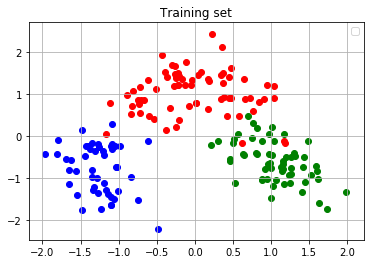

In [7]:
# TODO
# plt.scatter(Z[:,0],Z[:,1],marker='o',c='r')
# plt.show()

plt.rcParams.update({'font.size': 10})
inx=(y==2)
inx=inx.ravel()
plt.scatter(Z[inx,0],Z[inx,1],marker='o',color='b') 
inx=(y==1)
inx=inx.ravel()
plt.scatter(Z[inx,0],Z[inx,1],marker='o',color='r')  
inx=(y==0)
inx=inx.ravel()
plt.scatter(Z[inx,0],Z[inx,1],marker='o',color='g')    
plt.title("Training set")
plt.legend()
plt.grid()

plt.show()

Now, refit the scaled data `Xs` using `n_components=nfeatures` where `nfeatures` is the number of features.  This is the maximum number of PCs.  Get the singular values from `pca.singular_values_` and plot the portion of variation as a function of the number of PCs.   The PoV for using `n` PCs is:

    PoV[n]  = \sum_{i=0}^{n-1}  s[i]**2 / \sum_{i=0}^{d-1}  s[i]**2
    
where `s[i]` is the `i`-th singular value and `d` is the number of features.  You should see that the 4 PCs contains more than 70% of the variance.

In [0]:
# TODO
# Construct the PCA object
pca = PCA(n_components=n_features, svd_solver='randomized', whiten=True)
# Fit the PCA components on the entire dataset
pca.fit(Xs)
Z = pca.transform(Xs)

[28.94203422 21.08225141 16.04371561 12.78973645 12.32374195 10.68713954
  9.90368818  7.8760733   7.17081793  6.6828618   6.33958815  5.48097635
  4.28967045]


Text(0, 0.5, 'PoV')

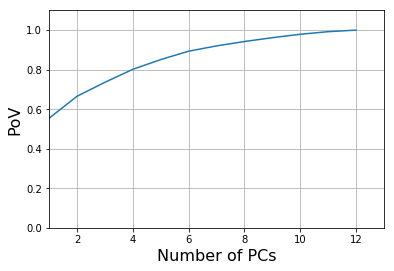

In [10]:
####################################################################
S=pca.singular_values_ 
print(S)
lam = S**2
PoV = np.cumsum(lam)/np.sum(lam)
Xsn_sample = Xs.shape[1]
plt.plot(PoV)
plt.grid()
plt.axis([1,Xsn_sample,0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

## Using PCA with Classification 

We will now use data scaling and PCA as a pre-processing step for logistic classification.  The number of PCs to use can be found with cross-validation.  Complete the code below which tries different number of PCs components to use and measures the test accuracy for each value.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
nfold = 5

# Create a K-fold object
kf = KFold(n_splits=nfold)
kf.get_n_splits(X)

# Number of PCs to try
ncomp_test = np.arange(2,12)
num_nc = len(ncomp_test)

# Accuracy:  acc[icomp,ifold]  is test accuracy when using `ncomp = ncomp_test[icomp]` in fold `ifold`.
acc = np.zeros((num_nc,nfold))

# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):
    
    # Look over the folds
    for ifold, I in enumerate(kf.split(X)):
        Itr, Its = I
        
        # TODO:  Split data into training 
        Xtr = X[Itr,:]
        ytr = y[Itr]
        Xts = X[Its,:]
        yts = y[Its]

        # TODO:  Create a scaling object and fit the scaling on the training data
        scaling = StandardScaler()
        Xtrs = scaling.fit_transform(Xtr)
        
        # TODO:  Fit the PCA on the scaled training data
        pca = PCA(n_components=ncomp, svd_solver='randomized', whiten=True)
        pca.fit(Xtrs)
        
        # TODO:  Train a classifier on the transformed training data
        # Use a logistic regression classifier
        Ztr = pca.transform(Xtrs)
        logreg = LogisticRegression(multi_class='auto', solver='lbfgs')
        logreg.fit(Ztr, ytr)
        
        # TODO:  Transform the test data through data scaler and PCA
        Xtss = scaling.transform(Xts)
        Zts = pca.transform(Xtss)
         
        # TODO:  Predict the labels the test data
        yhat = logreg.predict(Zts)
        
        # TODO:  Measure the accuracy 
        acc[icomp, ifold] = np.mean(yhat == yts)
        print('npc=%d nfold=%d acc=%12.4e' % (ncomp,ifold,acc[icomp, ifold]))


npc=2 nfold=0 acc=  9.1667e-01
npc=2 nfold=1 acc=  9.4444e-01
npc=2 nfold=2 acc=  8.8889e-01
npc=2 nfold=3 acc=  9.1429e-01
npc=2 nfold=4 acc=  9.7143e-01
npc=3 nfold=0 acc=  8.6111e-01
npc=3 nfold=1 acc=  9.4444e-01
npc=3 nfold=2 acc=  8.8889e-01
npc=3 nfold=3 acc=  9.4286e-01
npc=3 nfold=4 acc=  9.7143e-01
npc=4 nfold=0 acc=  8.6111e-01
npc=4 nfold=1 acc=  9.7222e-01
npc=4 nfold=2 acc=  8.8889e-01
npc=4 nfold=3 acc=  9.7143e-01
npc=4 nfold=4 acc=  9.7143e-01
npc=5 nfold=0 acc=  8.6111e-01
npc=5 nfold=1 acc=  8.8889e-01
npc=5 nfold=2 acc=  9.1667e-01
npc=5 nfold=3 acc=  9.7143e-01
npc=5 nfold=4 acc=  9.4286e-01
npc=6 nfold=0 acc=  9.4444e-01
npc=6 nfold=1 acc=  9.1667e-01
npc=6 nfold=2 acc=  9.1667e-01
npc=6 nfold=3 acc=  9.4286e-01
npc=6 nfold=4 acc=  9.4286e-01
npc=7 nfold=0 acc=  9.7222e-01
npc=7 nfold=1 acc=  9.4444e-01
npc=7 nfold=2 acc=  9.1667e-01
npc=7 nfold=3 acc=  9.4286e-01
npc=7 nfold=4 acc=  9.7143e-01
npc=8 nfold=0 acc=  9.7222e-01
npc=8 nfold=1 acc=  9.4444e-01
npc=8 nf

Use the `plt.errorbar` function to plot the mean accuracy with error bars corresponding to the standard error of the accuracy as a function of the number of components.  Find the optimal number of PCs to use according to the normal rule and one SE rule.  If you did it correctly, you should get an accuracy of around 96%.

Optimal model order with normal rule = 11
Optimal model order with one SE rule = 7


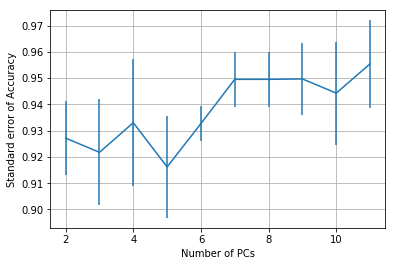

In [12]:
# TODO:
acc_mean = np.mean(acc,axis=1)
# acc_mean = np.mean(acc)
acc_se = np.std(acc,axis=1)/np.sqrt(nfold-1)
# acc_se = np.std(acc)/np.sqrt(nfold-1)
plt.errorbar(ncomp_test, acc_mean, acc_se)
plt.grid()
plt.xlabel('Number of PCs')
plt.ylabel('Standard error of Accuracy')

# TODO:  Optimal order with the normal rule
iopt = np.argmax(acc_mean)
dopt = ncomp_test[iopt]
print('Optimal model order with normal rule = %d' % dopt)

# TODO:  Optimal order with one SE rule
acc_tgt = acc_mean[iopt] - acc_se[iopt]
I = np.where(acc_mean >= acc_tgt)[0]
iopt_one_se = I[0]
dopt_one_se = ncomp_test[iopt_one_se]
print('Optimal model order with one SE rule = %d' % dopt_one_se)

## Hyper-Parameter Optimization with GridCV.

We will now try a more complex classifier -- a support vector classifier with a radial basis function.  When we use such a classifer, there will be a number of parameters to tune.  When the number of parameters to tune becomes large, writing a loop over multiple parameters as we did above becomes cumbersome.  The `sklearn` package has a very nice routine, `GridSearchCV` to perform this sort of parameter search.  

Before, we do this we need to create an estimator `Pipeline`.  An estimator pipeline is a sequence of transformations followed by an estimator that will operate on the transformed data.  Create the following pipeline:

*  Create a `StandardScaler()` object called `scaler` for the first transformation
*  Create a `PCA()` object called `pca` for the second transformation
*  Create a `SVC()` object called `svc` for the final SVM classifier.  Set the parameter `kernel='rbf'`.

Once you have the three steps defined, you can create the pipeline with the command:
    
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# TODO
scaler = StandardScaler()
pca = PCA()
svc = SVC()
pipe = Pipeline(steps = [('scaler',scaler),('pca',pca),('svc',svc)])
print(pipe)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])


We next define all the parameters that we want to search over.  Define the following arrays:

*  `ncomp_test`:  values from 3 to 10 representing number of PCs to test
*  `C_test`:  values of `C` in the SVC to test.  Use `10^{-2}, 10^{-1}, ... ,10^{3}` 
*  `gam_test`:  values of `gamma` in the SVC to test.  Use `10^{-3}, 10^{-2}, ... ,10^{1}` 

In [0]:
# TODO
ncomp_test = range(3,11)
c_test = [1e-2,1e-1,1,10,1e2,1e3]
gam_test = [1e-3,1e-2,1e-1,1,10]

Next, we create a dictionary `params` of the form:

    params =  {'pca__n_components': ncomp_test, 'svc__C' : c_test, ...}
    
Each key in the dictionary is the of the form `estimator__param` and the value is the values to be tested.

In [0]:
# TODO
params = {'pca__n_components':ncomp_test,'svc__C' : c_test,'svc__gamma':gam_test}

Finally, an object `estimator = GridSearchCV(...)` from  `pipe` and `params`.  Set `cv=5`, `train_score=True` and `iid=False`.  Fit the estimator from the data `X,y`.  Then the estimator will perform the cross-validation over all the parameters.  This may take a minute since we are search over so many parameters.

In [17]:
# TODO
estimator = GridSearchCV(pipe,params, cv = 5, iid = False,)
estimator.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'pca__n_components': range(3, 11), 'svc__C': [0.01, 0.1, 1, 10, 100.0, 1000.0], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Print the best test score and best parameters.  They are fields in `estimator`.  If you did it correctly, it should be a little higher than the logistic regression (about 0.97 to 0.98 accuracy).

In [18]:
# TODO
print('best accuracy={0}',format(estimator.best_score_))

best accuracy={0} 0.978078078078078


Finally, you can get the test score for all the parameter choices from 

    test_score = estimator.cv_results_['mean_test_score']
    
Use the `imshow` command to plot the mean test score over `gamma` and `C` for the value `n_components=5`.

In [22]:
print('best parameter={0}', format(estimator.best_params_))

best parameter={0} {'pca__n_components': 5, 'svc__C': 1, 'svc__gamma': 0.1}


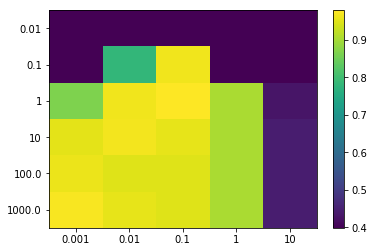

In [23]:
# TODO
test_score = estimator.cv_results_['mean_test_score'].reshape(8,6,5)
P = plt.gca()
P.set_xticks(np.arange(0,len(gam_test)))
P.set_xticklabels(gam_test)
P.set_yticks(np.arange(0,len(c_test)))
P.set_yticklabels(c_test)
plt.imshow(test_score[2],aspect='auto')
plt.colorbar()